In [2]:
import lightgbm as lgb
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from optuna.integration import LightGBMPruningCallback
import joblib
import warnings
import pickle

warnings.filterwarnings('ignore')

/home/apprenant/Documents/Projets/ML/SBA_Loan_App/BriefApp/DjangoAPI/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Charger les données
data = pd.read_parquet('SBAnational_ML_Dorothee.parquet')

In [4]:
data.head(3)

,Bank,GrAppv,Term,State,ApprovalYear,NAICS_Sectors,New,Franchise,NoEmp,CreateJob,RetainedJob,RevLineCr,LowDoc,Rural,Crisis,PIF
0,FIFTH THIRD BANK,60000,84,IN,1997,45,1.0,0,4,0,0,0.0,1.0,NaN,0,1
1,1ST SOURCE BANK,40000,60,IN,1997,72,1.0,0,2,0,0,0.0,1.0,NaN,0,1
2,GRANT COUNTY STATE BANK,287000,180,IN,1997,62,0.0,0,7,0,0,0.0,0.0,NaN,0,1


In [5]:
dtype_dict = {
    "GrAppv": "float32",
    "Term": "float32",
    "State": "category",
    "NAICS_Sectors": "category",
    "New": "category",
    "Franchise": "category",
    "NoEmp": "float32",
    "RevLineCr": "category",
    "LowDoc": "category",
    "Rural": "category",
    "PIF": "category"
}

data = data.astype(dtype_dict)

In [6]:
data.drop(columns=['Bank', 'ApprovalYear', 'CreateJob', 'RetainedJob', 'Crisis'], inplace=True)

,GrAppv,Term,State,NAICS_Sectors,New,Franchise,NoEmp,RevLineCr,LowDoc,Rural,PIF
0,60000.0,84.0,IN,45,1.0,0,4.0,0.0,1.0,NaN,1
1,40000.0,60.0,IN,72,1.0,0,2.0,0.0,1.0,NaN,1
2,287000.0,180.0,IN,62,0.0,0,7.0,0.0,0.0,NaN,1
3,35000.0,60.0,OK,NaN,0.0,0,2.0,0.0,1.0,NaN,1
4,229000.0,240.0,FL,NaN,0.0,0,14.0,0.0,0.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...
899159,70000.0,60.0,OH,45,0.0,0,6.0,NaN,0.0,NaN,1
899160,85000.0,60.0,OH,45,0.0,0,6.0,1.0,0.0,NaN,1
899161,300000.0,108.0,CA,33,0.0,0,26.0,0.0,0.0,NaN,1
899162,75000.0,60.0,HI,NaN,0.0,0,6.0,0.0,1.0,NaN,0


In [ ]:
data[:99].to_csv('data_django.csv', index=False)

In [ ]:
category_columns = ['State', 'NAICS_Sectors', 'New', 'Franchise', 'RevLineCr', 'LowDoc', 'Rural']
numeric_columns = ['Term', 'GrAppv', 'NoEmp']

categories_dict = {}

for col in category_columns:
    data[col] = data[col].astype("category")
    categories_dict[col] = data[col].cat.categories  # Sauvegarder les catégories
    data[col] = data[col].cat.codes

In [ ]:
# Séparer les caractéristiques et la cible
X = data.drop('PIF', axis=1)  # Remplacez 'PIF' par le nom de votre colonne cible
y = data['PIF']

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [ ]:
# Sauvegarder les catégories dans un fichier
with open("categories.pkl", "wb") as f:
    pickle.dump(categories_dict, f)

print("Catégories sauvegardées :", categories_dict)

Catégories sauvegardées : {'State': Index(['AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 'GA', 'HI',
       'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN',
       'MO', 'MS', 'MT', 'NC', 'ND', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', 'OH',
       'OK', 'OR', 'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 'VA', 'VT', 'WA',
       'WI', 'WV', 'WY'],
      dtype='object'), 'NAICS_Sectors': Index(['11', '21', '22', '23', '31', '32', '33', '42', '44', '45', '48', '49',
       '51', '52', '53', '54', '55', '56', '61', '62', '71', '72', '81', '92'],
      dtype='object'), 'New': Index([0.0, 1.0], dtype='float64'), 'Franchise': Index([0, 1], dtype='int64'), 'RevLineCr': Index([0.0, 1.0], dtype='float64'), 'LowDoc': Index([0.0, 1.0], dtype='float64'), 'Rural': Index([0.0, 1.0], dtype='float64')}


In [ ]:
# Définir le modèle LightGBM
lgbm_model = lgb.LGBMClassifier(objective='binary', metric='auc', boosting_type='gbdt')


# Fonction pour optimiser les hyperparamètres via Optuna
def objective(trial):
    param = {
        'lgbm__objective': 'binary',  # Classification binaire
        'lgbm__metric': 'auc',        # Utilisation de l'AUC comme métrique
        'lgbm__boosting_type': 'gbdt', # Type de boosting (Gradient Boosting Decision Tree)
        'lgbm__lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lgbm__lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'lgbm__num_leaves': trial.suggest_int('num_leaves', 10, 100),
        'lgbm__learning_rate': trial.suggest_loguniform('learning_rate', 1e-3, 0.1),
        'lgbm__feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'lgbm__bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'lgbm__bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lgbm__min_child_samples': trial.suggest_int('min_child_samples', 5, 100)
    }

    lgbm_model.set_params(**param)
    
    # Validation croisée avec scores AUC
    scores = cross_val_score(lgbm_model, X_train, y_train, cv=5, scoring='roc_auc')
    return scores.mean()

# Lancer l'optimisation des hyperparamètres avec Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=600)


[I 2025-02-24 15:37:12,969] A new study created in memory with name: no-name-7a56b1e4-d43d-48eb-a4ca-8bb34691fa3c
[W 2025-02-24 15:37:13,345] Trial 0 failed with parameters: {'lambda_l1': 5.314778560807026e-07, 'lambda_l2': 1.2414147285506012, 'num_leaves': 88, 'learning_rate': 0.00755730016860758, 'feature_fraction': 0.585445961484112, 'bagging_fraction': 0.7794527341078958, 'bagging_freq': 7, 'min_child_samples': 60} because of the following error: ValueError('\nAll the 5 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n5 fits failed with the following error:\nTraceback (most recent call last):\n  File "/home/apprenant/Documents/Projets/ML/SBA_Loan_App/BriefApp/DjangoAPI/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score\n 

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/home/apprenant/Documents/Projets/ML/SBA_Loan_App/BriefApp/DjangoAPI/.venv/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/apprenant/Documents/Projets/ML/SBA_Loan_App/BriefApp/DjangoAPI/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 1560, in fit
    super().fit(
  File "/home/apprenant/Documents/Projets/ML/SBA_Loan_App/BriefApp/DjangoAPI/.venv/lib/python3.12/site-packages/lightgbm/sklearn.py", line 949, in fit
    _X, _y = _LGBMValidateData(
             ^^^^^^^^^^^^^^^^^^
  File "/home/apprenant/Documents/Projets/ML/SBA_Loan_App/BriefApp/DjangoAPI/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2919, in validate_data
    _check_feature_names(_estimator, X, reset=reset)
  File "/home/apprenant/Documents/Projets/ML/SBA_Loan_App/BriefApp/DjangoAPI/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py", line 2717, in _check_feature_names
    estimator.feature_names_in_ = feature_names_in
    ^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: property 'feature_names_in_' of 'LGBMClassifier' object has no setter


In [ ]:
# Affichage des meilleurs hyperparamètres
print("Best hyperparameters: ", study.best_params)

Best hyperparameters:  {'lambda_l1': 4.037992456836949e-06, 'lambda_l2': 1.1434515939209712e-05, 'num_leaves': 93, 'learning_rate': 0.09728935582893676, 'feature_fraction': 0.8258321090830866, 'bagging_fraction': 0.6180539559065807, 'bagging_freq': 5, 'min_child_samples': 52}


In [ ]:
# Définir les meilleurs hyperparamètres trouvés par Optuna
best_params = study.best_params

# Mettre à jour les noms des paramètres pour qu'ils correspondent à ceux attendus par le pipeline
best_params = {f'lgbm__{key}': value for key, value in best_params.items()}

# Appliquer les meilleurs hyperparamètres au pipeline
lgbm_model.set_params(**best_params)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['State', 'NAICS_Sectors',
                                                   'New', 'Franchise',
                                                   'RevLineCr', 'LowDoc',
                                                   'Rural'])])),
                ('lgbm',
                 LGBMClassifier(bagging_fraction=0.6180539559065807,
                                bagging_freq=5,
                                feature_fraction=0.8258321090830866,
                                lambda_l1=4.037992456836949e-06,
                                lambda_l2=1.1434515939209712e-05,
                                learning_rate=0.09728935582893676, metric='auc',
                                min_child_samples=52, num_leaves=93,
                                objective='binary'))])

In [ ]:
lgbm_model.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.8258321090830866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258321090830866
[LightGBM] [Warning] lambda_l2 is set=1.1434515939209712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1434515939209712e-05
[LightGBM] [Warning] lambda_l1 is set=4.037992456836949e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.037992456836949e-06
[LightGBM] [Warning] bagging_fraction is set=0.6180539559065807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6180539559065807
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.8258321090830866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258321090830866
[LightGBM] [Warning] lambda_l2 is set=1.1434515939209712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1434515939209712e-05
[LightGBM] [Wa

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['State', 'NAICS_Sectors',
                                                   'New', 'Franchise',
                                                   'RevLineCr', 'LowDoc',
                                                   'Rural'])])),
                ('lgbm',
                 LGBMClassifier(bagging_fraction=0.6180539559065807,
                                bagging_freq=5,
                                feature_fraction=0.8258321090830866,
                                lambda_l1=4.037992456836949e-06,
                                lambda_l2=1.1434515939209712e-05,
                                learning_rate=0.09728935582893676, metric='auc',
                                min_child_samples=52, num_leaves=93,
                                objective='binary'))])

In [ ]:
# Save the pipeline
joblib.dump(lgbm_model, 'final_model_pipeline.pkl')

['final_model_pipeline.pkl']

In [ ]:
# Predictions and evaluation
y_pred_proba = lgbm_model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

[LightGBM] [Warning] feature_fraction is set=0.8258321090830866, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8258321090830866
[LightGBM] [Warning] lambda_l2 is set=1.1434515939209712e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1434515939209712e-05
[LightGBM] [Warning] lambda_l1 is set=4.037992456836949e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.037992456836949e-06
[LightGBM] [Warning] bagging_fraction is set=0.6180539559065807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6180539559065807
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


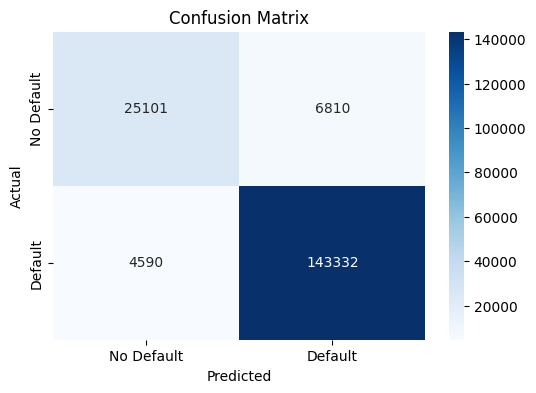

In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Default', 'Default'], yticklabels=['No Default', 'Default'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

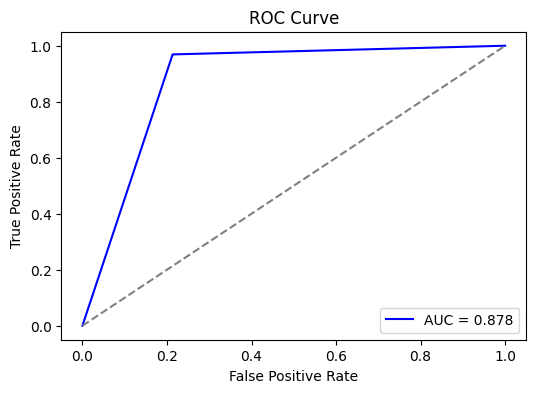

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

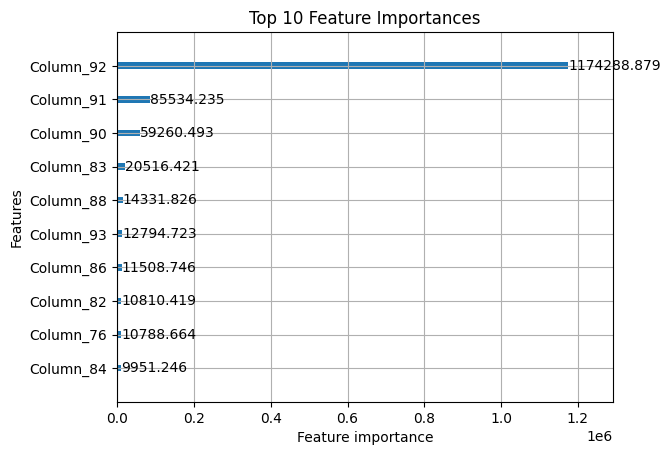

Final Model Accuracy: 0.937


In [ ]:
# Feature Importance

lgb.plot_importance(lgbm_model.named_steps['lgbm'], max_num_features=10, importance_type='gain')
plt.title('Top 10 Feature Importances')
plt.show()

print(f'Final Model Accuracy: {accuracy_score(y_test, y_pred):.3f}')

In [ ]:
some_data = data.iloc[:5]
some_data.to_csv('some_data.csv', index=False)

In [ ]:
some_data

,GrAppv,Term,State,NAICS_Sectors,New,Franchise,NoEmp,RevLineCr,LowDoc,Rural,PIF
0,60000.0,84.0,IN,45,1.0,0,4.0,0.0,1.0,NaN,1
1,40000.0,60.0,IN,72,1.0,0,2.0,0.0,1.0,NaN,1
2,287000.0,180.0,IN,62,0.0,0,7.0,0.0,0.0,NaN,1
3,35000.0,60.0,OK,NaN,0.0,0,2.0,0.0,1.0,NaN,1
4,229000.0,240.0,FL,NaN,0.0,0,14.0,0.0,0.0,NaN,1


In [ ]:
# Charger les catégories sauvegardées
with open("categories.pkl", "rb") as f:
    loaded_categories = pickle.load(f)

# Appliquer les catégories aux nouvelles données
for col in categorical_columns:
    X_test[col] = X_test[col].astype("category")
    X_test[col] = X_test[col].cat.set_categories(loaded_categories[col])  # Aligner les catégories
    X_test[col] = X_test[col].cat.codes

print("Données de test encodées :")
print(X_test.head())